In [ ]:
import pandas as pd
import regex as re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from string import punctuation
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# ********************IMPORTANT INSTRUCTIONS************************

# Relevant results are in the section under "Start BERT model", everything up to that point to get results 

# **Importing data**

In [ ]:
# Import data

df = pd.read_csv("/content/occ-mgr-logs-2022-0124-0131 (1).csv")
df

,_time,ENTRY
0,2022-01-28T02:06:00.000-0800,EOR.
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w..."
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.
...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba..."
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.


It seems that the data has no label.

# **Data Cleaning**

It seems that there are a lot of stopwords that will impact the model. 

Some examples of stopwords (i.e.,not important words) are as follows:

- Txxx
- Mxx-x
- etc.

Where x represents digits.

The function called `text_cleaning` is used for text cleaning the log column. This function will generate new column called `cleaned_log`.

In [ ]:
# Functions for text cleaning
def removeDigit(lst): 
    pattern = '[0-9]'
    lst = [re.sub(pattern, '', i) for i in lst] 
    return lst

def remove_punctuation(document):
    no_punct = ''.join([character for character in document if character not in punctuation])
    return no_punct

def remove_digit(document): 
    no_digit = ''.join([character for character in document if not character.isdigit()])         
    return no_digit

stop_words = set(stopwords.words('english'))
def remove_stopwords(document):
    words = [word for word in document if not word in stop_words]
    return words

porter = PorterStemmer()

def stemmer(document):
    stemmed_document = [porter.stem(word) for word in document]
    return stemmed_document

In [ ]:
def text_cleaning(df):

  # Initialize
  df['cleaned_entry'] = df['ENTRY']

  # Remove stop words
  # e.g., T231, A90-2, M16
  stop_words = [r"[A-Z]\d{3}",r"\w\d{2}\-\d",r"[A-Z]\d{2}"]
  for word in stop_words:
    df['cleaned_entry'] = df['cleaned_entry'].str.replace(word,"")

  # Lower text
  df['cleaned_entry'] = df['cleaned_entry'].str.lower()

  # Remove digits
  df['cleaned_entry'] = df['cleaned_entry'].str.replace('[0-9]','')

  # Remove punctuation
  punctuations = [x for x in punctuation]
  for p in punctuations:
    df['cleaned_entry'] = df['cleaned_entry'].str.replace(p,"")

  # Drop NA
  df = df.dropna()

  # Tokenize words
  df['cleaned_entry'] = df['cleaned_entry'].apply(word_tokenize)

  # Remove english stop words
  df['cleaned_entry'] = df['cleaned_entry'].apply(remove_stopwords)

  # Apply stemmer
  df['cleaned_entry'] = df['cleaned_entry'].apply(stemmer)

  # Detokenize text
  df['cleaned_entry'] = df['cleaned_entry'].apply(TreebankWordDetokenizer().detokenize)

  # Drop NA and reindex
  df = df.dropna().reset_index(drop = True)

  return df

Now, we can begin text cleaning.

In [ ]:
# Begin text cleaning

df = text_cleaning(df)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,_time,ENTRY,cleaned_entry
0,2022-01-28T02:06:00.000-0800,EOR.,eor
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w...",sa report sleeper platform get leav station bp...
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish
...,...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...,kma substat offlin safe clear fix pl ad platform
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba...",mline rline lline blanket releas back central
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.,elin doc
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.,ventil report


# Start bert model

## Problem: We are given the data which contains the timestamp and entry columns. The task is that we have to classify the entry column. The way you cluster the entry (i.e., the label name and how many clusters) is up to you. 



Using BERT: https://github.com/UKPLab/sentence-transformers

In [ ]:
pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 4.0 MB 33.8 MB/s 
     |████████████████████████████████| 1.2 MB 63.6 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
     |████████████████████████████████| 895 kB 85.5 MB/s 
     |████████████████████████████████| 6.6 MB 44.5 MB/s 
     |████████████████████████████████| 596 kB 88.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=5dbc2db8b17437559a2a3c7195d88091e5ef6bb0a4074087e1058e9e6c7874ba
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Using BERT, we can simply extract embeddings/representations from the model to use for our purposes

In [ ]:
sentences = df['cleaned_entry']
sentence_embeddings = model.encode(sentences)

In [ ]:
sentence_embeddings.shape

(1330, 384)

## We can now use Kmeans to create labels for the sentence embeddings.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
class KMeans_model():
  def __init__(self,df):
    self.df = df
  
  def km_score(self,K):
    distortions = []
    silhouette_scores = []

    for k in range(2,K):

      # Introduce kmeans model
      km = KMeans(n_clusters=k)
      km.fit(self.df)

      # Elbow Method
      distortions.append(km.inertia_)

    fig, axs = plt.subplots(1,1, figsize = (12,12))

    # Plotting Elbow Method
    axs.plot(range(2,K), distortions, 'bx-')
    axs.set_title('Elbow Method')
    axs.axvline(x=15) # k is selected at the 'elbow'

  def assign_label(self,k):
    km = KMeans(n_clusters=k, random_state = 88)
    km.fit(self.df)
    result = km.predict(self.df)
    return result

In [ ]:
km = KMeans_model(sentence_embeddings)

In [ ]:
pred_labels = km.assign_label(8) # arbitrary number of classes

In [ ]:
df['no_label'] = pred_labels

In [ ]:
df.head()

,_time,ENTRY,cleaned_entry,no_label
0,2022-01-28T02:06:00.000-0800,EOR.,eor,7
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish,0
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish,0
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w...",sa report sleeper platform get leav station bp...,7
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish,0


In [ ]:
df['no_label'].value_counts()

7    339
2    272
4    239
1    236
5    102
0     62
3     50
6     30
Name: no_label, dtype: int64

## Interpreting the labels requires a human in the loop.

In [ ]:
df[df['no_label'] == 0]

,_time,ENTRY,cleaned_entry,no_label
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish,0
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish,0
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish,0
164,2022-01-27T04:57:00.000-0800,Core Line Blanket released back to Central. Al...,core line blanket releas back central blanket ...,0
168,2022-01-27T04:29:00.000-0800,L-Line Blanket released back to Central.,lline blanket releas back central,0
...,...,...,...,...
1322,2022-01-29T05:33:00.000-0800,W-Line Blanket released back to Central.,wline blanket releas back central,0
1323,2022-01-29T05:08:00.000-0800,C-Line Blanket released back to Central.,cline blanket releas back central,0
1324,2022-01-29T05:03:00.000-0800,A Line Blanket released back to Central. S-Lin...,line blanket releas back central sline blanket...,0
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba...",mline rline lline blanket releas back central,0


## Delays

In [ ]:
df[df['no_label'] == 1]

,_time,ENTRY,cleaned_entry,no_label
6,2022-01-28T01:31:00.000-0800,"(ref 0027) T323 released ATO, now (14) minutes...",ref releas ato minut late,1
30,2022-01-27T22:13:00.000-0800,"(ref 2159) T219 released ATO, now (5) minutes ...",ref releas ato minut late,1
39,2022-01-27T19:39:00.000-0800,(ref 1934) T405 is released ATO (720) seconds ...,ref releas ato second late second late second ...,1
42,2022-01-27T19:11:00.000-0800,(ref 1903) T315 released ATO (1842) seconds late.,ref releas ato second late,1
44,2022-01-27T18:50:00.000-0800,(ref 1841) T513 released (1815) seconds late.,ref releas second late,1
...,...,...,...,...
1302,2022-01-29T07:54:00.000-0800,(ref 0749) T105 released ATO. (105) second delay.,ref releas ato second delay,1
1303,2022-01-29T07:54:00.000-0800,(ref 0753) T201 released ATO.,ref releas ato,1
1310,2022-01-29T06:53:00.000-0800,(ref 0646) T103 released ATO. (156) second delay.,ref releas ato second delay,1
1311,2022-01-29T06:48:00.000-0800,(ref 0631) T307 released ATO. (560) second delay.,ref releas ato second delay,1


In [ ]:
df[df['no_label'] == 2]

,_time,ENTRY,cleaned_entry,no_label
5,2022-01-28T01:33:00.000-0800,BPD requesting an extended dwell at W30-1 for ...,bpd request extend dwell,2
14,2022-01-28T00:27:00.000-0800,T323 BPD hold at M40-1 for a sweep. (32),bpd hold sweep,2
15,2022-01-28T00:27:00.000-0800,T203 BPD hold at A90 for BPD sweeps. (31),bpd hold bpd sweep,2
18,2022-01-28T00:00:00.000-0800,T319 BPD hold at M40-1 for a sweep. (30),bpd hold sweep,2
21,2022-01-27T23:53:00.000-0800,T225 BPD hold at A90-1 for a Sweep. (29),bpd hold sweep,2
...,...,...,...,...
1304,2022-01-29T07:53:00.000-0800,T201 A90-2 BPD hold A90-2 for lodgers & mask v...,bpd hold lodger mask violat,2
1306,2022-01-29T07:49:00.000-0800,T105 M16-1 BPD hold M30-1 for a disturbance. (4),bpd hold disturb,2
1312,2022-01-29T06:46:00.000-0800,T103 approaching A60-2 BPD hold A50-2 for some...,approach bpd hold someon brandish knife,2
1314,2022-01-29T06:34:00.000-0800,T315 K20-3 BPD hold K30-3 for a disturbance on...,bpd hold disturb board,2


## staff shortage

In [ ]:
df[df['no_label'] == 3]

,_time,ENTRY,cleaned_entry,no_label
17,2022-01-28T00:02:00.000-0800,R60 is staffed again.,staf,3
22,2022-01-27T23:32:00.000-0800,C60 is staffed again.,staf,3
50,2022-01-27T18:33:00.000-0800,T321 is a hole Y10-1 due to staffing and recov...,hole due staf recoveri major delay,3
64,2022-01-27T16:11:00.000-0800,T123 hole S50-M90 roundtrip UFN due to staffin...,hole roundtrip ufn due staf shortag,3
70,2022-01-27T15:26:00.000-0800,T117 hole S50-M90 roundtrip UFN due to staffin...,hole roundtrip ufn due staf shortag,3
73,2022-01-27T15:00:00.000-0800,T213 hole S50-R60 roundtrip UFN due to staffin...,hole roundtrip ufn due staf shortag,3
81,2022-01-27T13:11:00.000-0800,T123 hole S50-M90 roundtrip UFN due to staffin...,hole roundtrip ufn due staf shortag,3
88,2022-01-27T12:26:00.000-0800,T117 hole S50-M90 roundtrip UFN due to staffin...,hole roundtrip ufn due staf shortag,3
89,2022-01-27T12:00:00.000-0800,T213 hole S50-R60 roundtrip UFN due to staffin...,hole roundtrip ufn due staf shortag,3
97,2022-01-27T11:07:00.000-0800,"T509 L30-1 late departing, T/O boarded L30-2 F...",late depart board fw fail advis rotat platform...,3


## potential issues with this approach: 
Neither BERT nor Kmeans are autoregressive, so we cannot get density estimates for these predicted classes.

Interpreting the predicted classes has to be human done.

How many classes is appropriate for k-means, is also problematic, even with metrics like elbow method since the most information gain doesn't necessary correspond to usefulness in the real world.

# End BERT model

# New LSTM Autoencoder Model

## just some brief work using LSTMs that I didn't continue because BERT was likely to be better. Next steps to continue this would be to extract the encoder and then use kmeans again to extract labels.

## process data

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2,random_state=0)

train_sentences = df_train['cleaned_entry']# .to_numpy()
test_sentences = df_test['cleaned_entry']#.to_numpy()

import keras.utils

# Number of unique words in df
vocab_size = len(np.unique([item for sublist in \
                            [entry for entry in df['cleaned_entry']\
                             .apply(word_tokenize)] for item in sublist]))
embedding_dim = 128
max_length = max([len(entry) for entry in df['cleaned_entry'].apply(word_tokenize)])
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(list(train_sentences))
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(list(test_sentences))
test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating=trunc_type)


# scale data
t = MinMaxScaler()
t.fit(train_padded)
train_padded = t.transform(train_padded)
test_padded = t.transform(test_padded)

## model

In [ ]:
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# define input sequence
num_seq, len_seq = train_padded.shape
# seq_in = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
# n_in = len(seq_in)
seq_in = train_padded.reshape((num_seq, len_seq, 1))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_in = len_seq
n_out = len_seq - 1
# define encoder
visible = Input(shape=(n_in,1))
encoder = LSTM(100, activation='relu')(visible)
# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)
# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)
# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
# plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')
# fit model
# model.fit(seq_in, [seq_in,seq_out], epochs=300, verbose=0)
# demonstrate prediction
# yhat = model.predict(seq_in, verbose=0)
# print(yhat)


# compile autoencoder model
history = model.fit(seq_in, [seq_in, seq_out], epochs=300,
                    batch_size=16, verbose=2)

Epoch 1/300
67/67 - 16s - loss: 0.0150 - time_distributed_2_loss: 0.0074 - time_distributed_3_loss: 0.0076 - 16s/epoch - 238ms/step
Epoch 2/300
67/67 - 8s - loss: 0.0161 - time_distributed_2_loss: 0.0078 - time_distributed_3_loss: 0.0083 - 8s/epoch - 120ms/step
Epoch 3/300
67/67 - 8s - loss: 0.0156 - time_distributed_2_loss: 0.0076 - time_distributed_3_loss: 0.0079 - 8s/epoch - 116ms/step
Epoch 4/300
67/67 - 7s - loss: 0.0168 - time_distributed_2_loss: 0.0084 - time_distributed_3_loss: 0.0085 - 7s/epoch - 111ms/step
Epoch 5/300
67/67 - 5s - loss: 0.0149 - time_distributed_2_loss: 0.0076 - time_distributed_3_loss: 0.0073 - 5s/epoch - 72ms/step
Epoch 6/300
67/67 - 5s - loss: 0.0146 - time_distributed_2_loss: 0.0072 - time_distributed_3_loss: 0.0074 - 5s/epoch - 73ms/step
Epoch 7/300
67/67 - 5s - loss: 0.0153 - time_distributed_2_loss: 0.0088 - time_distributed_3_loss: 0.0065 - 5s/epoch - 74ms/step
Epoch 8/300
67/67 - 5s - loss: 0.0141 - time_distributed_2_loss: 0.0081 - time_distributed_

# **Classification Autoencoders**

## **Model**

**Source:**  
- https://machinelearningmastery.com/lstm-autoencoders/
- https://machinelearningmastery.com/autoencoder-for-classification/
- https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb
- https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb



Split the dataframe into `df_train` (80%) and `df_test` (20%). Then, create `train_sentences` and `test_sentences` which extracted from `cleaned_entry` column from `df`.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2,random_state=0)

train_sentences = df_train['cleaned_entry']# .to_numpy()
test_sentences = df_test['cleaned_entry']#.to_numpy()

Then, we want to construct `train_padded` and `test_padded`, which contains the words converted to padded sequences.

In [ ]:
import keras.utils

# Number of unique words in df
vocab_size = len(np.unique([item for sublist in \
                            [entry for entry in df['cleaned_entry']\
                             .apply(word_tokenize)] for item in sublist]))
embedding_dim = 128
max_length = max([len(entry) for entry in df['cleaned_entry'].apply(word_tokenize)])
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(list(train_sentences))
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(list(test_sentences))
test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
# The percentage of <OOV> in the test_padded

OOV_percent = sum([x.count(1) for x in test_sequences])/sum([len(x) for x in test_sequences]) * 100
print("OOV Percent: ", np.round(OOV_percent,3),'%')

OOV Percent:  5.685 %


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale data
t = MinMaxScaler()
t.fit(train_padded)
train_padded = t.transform(train_padded)
test_padded = t.transform(test_padded)

Now, we are ready to define the model.

In [ ]:
from keras.layers import Input, BatchNormalization, LeakyReLU
from keras import Model

In [ ]:
n_inputs = len(train_padded[0])

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)


# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_padded, train_padded, epochs=200,
                    batch_size=16, verbose=2, validation_data=(test_padded,test_padded))

Epoch 1/200
67/67 - 2s - loss: 0.1822 - val_loss: 0.0086 - 2s/epoch - 32ms/step
Epoch 2/200
67/67 - 0s - loss: 0.0313 - val_loss: 0.0086 - 208ms/epoch - 3ms/step
Epoch 3/200
67/67 - 0s - loss: 0.0180 - val_loss: 0.0078 - 194ms/epoch - 3ms/step
Epoch 4/200
67/67 - 0s - loss: 0.0131 - val_loss: 0.0064 - 249ms/epoch - 4ms/step
Epoch 5/200
67/67 - 0s - loss: 0.0110 - val_loss: 0.0055 - 224ms/epoch - 3ms/step
Epoch 6/200
67/67 - 0s - loss: 0.0096 - val_loss: 0.0047 - 268ms/epoch - 4ms/step
Epoch 7/200
67/67 - 0s - loss: 0.0079 - val_loss: 0.0048 - 266ms/epoch - 4ms/step
Epoch 8/200
67/67 - 0s - loss: 0.0071 - val_loss: 0.0042 - 213ms/epoch - 3ms/step
Epoch 9/200
67/67 - 0s - loss: 0.0067 - val_loss: 0.0043 - 228ms/epoch - 3ms/step
Epoch 10/200
67/67 - 0s - loss: 0.0065 - val_loss: 0.0040 - 264ms/epoch - 4ms/step
Epoch 11/200
67/67 - 0s - loss: 0.0060 - val_loss: 0.0038 - 198ms/epoch - 3ms/step
Epoch 12/200
67/67 - 0s - loss: 0.0058 - val_loss: 0.0036 - 202ms/epoch - 3ms/step
Epoch 13/200
67

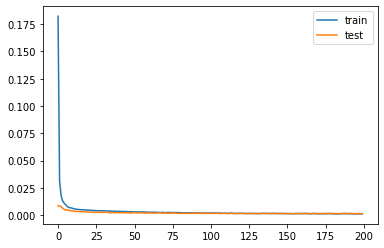

In [ ]:
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **Data for encoder**

In [ ]:
# Defining data for input to encoder

df_sentences = df['cleaned_entry'] # sentences in the dataframe
df_sequences = tokenizer.texts_to_sequences(list(df_sentences)) # Converting to sequences
df_padded = pad_sequences(df_sequences,maxlen=max_length, truncating=trunc_type) # Padding the sequences
df_padded_normalized = t.transform(df_padded) # Normalizing the padded sequences

## **Encoder**

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

In [ ]:
# encode the train data
df_padded_encode = encoder.predict(df_padded_normalized)

In [ ]:
df_padded_encode.shape

(1330, 42)

## **Clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
class KMeans_model():
  def __init__(self,df):
    self.df = df
  
  def km_score(self,K):
    distortions = []
    silhouette_scores = []

    for k in range(2,K):

      # Introduce kmeans model
      km = KMeans(n_clusters=k)
      km.fit(self.df)

      # Elbow Method
      distortions.append(km.inertia_)

    fig, axs = plt.subplots(1,1, figsize = (12,12))

    # Plotting Elbow Method
    axs.plot(range(2,K), distortions, 'bx-')
    axs.set_title('Elbow Method')
    axs.axvline(x=15) # k is selected at the 'elbow'

  def assign_label(self,k):
    km = KMeans(n_clusters=k, random_state = 88)
    km.fit(self.df)
    result = km.predict(self.df)
    return result

In [ ]:
# Initialize class

km = KMeans_model(df_padded_encode)

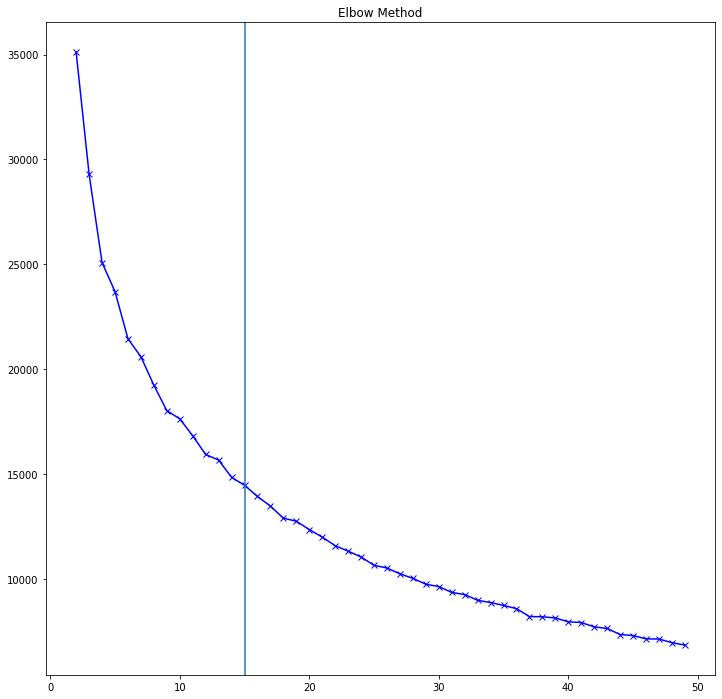

In [ ]:
km.km_score(50)

The elbow is at k = 15.

In [ ]:
pred_label = km.assign_label(15)

In [ ]:
df['no_label'] = pred_label
df

,_time,ENTRY,cleaned_entry,no_label
0,2022-01-28T02:06:00.000-0800,EOR.,eor,3
1,2022-01-28T02:02:00.000-0800,M-Line Blanket established.,mline blanket establish,0
2,2022-01-28T01:52:00.000-0800,A-Line Blanket established.,alin blanket establish,0
3,2022-01-28T01:45:00.000-0800,"SA at M60 reports a sleeper on the platform, w...",sa report sleeper platform get leav station bp...,12
4,2022-01-28T01:38:00.000-0800,Core-Line Blanket established.,corelin blanket establish,8
...,...,...,...,...
1325,2022-01-29T04:51:00.000-0800,KMA substation will be offline and safe cleare...,kma substat offlin safe clear fix pl ad platform,12
1326,2022-01-29T04:46:00.000-0800,"M-Line, R-Line and L-Line Blankets released ba...",mline rline lline blanket releas back central,1
1327,2022-01-29T03:00:00.000-0800,E-Line Docs.,elin doc,9
1328,2022-01-29T03:00:00.000-0800,Ventilation Report for 1/28/22.,ventil report,3


## **Assigning topic**

In [ ]:
df['no_label'].value_counts()

4     386
3     235
9     172
0     153
1     115
12     66
2      62
14     58
8      47
11     25
5       7
6       1
10      1
7       1
13      1
Name: no_label, dtype: int64

In [ ]:
df[df['no_label'] == 7]

,_time,ENTRY,cleaned_entry,no_label
836,2022-01-24T22:18:00.000-0800,"T207 moving ATO our of Richmond, 25 minutes la...",move ato richmond minut late ori tower call sa...,7
